## *Import Libraries*

In [ ]:
# ========== Required Libraries ==========
import re
import csv
import nltk
import spacy
import numpy as np 
import pandas as pd
import contractions
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

## *Load Dataset*

In [ ]:

with open('/kaggle/input/mit-plagairism-detection-dataset/train_snli.txt') as file:
    data = file.readlines()
    
with open('data.csv', 'w', newline= '') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)
    
    writer.writeheader()
    for line in tqdm(data):
        parts = line.strip().split('\t')
        source_txt = parts[0]
        plagiarishm_txt = parts[1]
        label = int(parts[2])
        
        writer.writerow({
            'source_txt' : source_txt,
            'plagiarism_txt' : plagiarishm_txt,
            'label' : label
        })
print('CSV file created successfully...')

  0%|          | 0/367373 [00:00<?, ?it/s]

CSV file created successfully...


## *Top 5 Data*

In [3]:
df = pd.read_csv("data.csv")
df.sample(5)

,source_txt,plagiarism_txt,label
145262,A woman wearing glasses and a hat pokes her he...,A woman is outdoors.,1
34755,Two children playing on a statue,the children are asleep,0
262465,The skateboarder wearing jeans and a white shi...,A person on a skateboard in mid air near a ramp.,1
288170,There is a woman and man wearing orange shirts...,A man and a woman and paying musical instruments.,1
298468,People running a foot race make a right turn a...,the people are racing,1


## *Shape of Data*

In [13]:
df.shape

(367373, 3)

## *Check Missing Values*

In [4]:
# check for null values
print("Null values",df.isnull().sum())
# remove null values
df.dropna(inplace=True)
# check for null values after removing
print("==============================")
print("Null values after removing :",df.isnull().sum())

Null values source_txt        0
plagiarism_txt    4
label             0
dtype: int64
Null values after removing : source_txt        0
plagiarism_txt    0
label             0
dtype: int64


## *Check value is Duplicate?*

In [5]:
# check for duplicates
print("Duplicates",df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)
# check for duplicates after removing
print("==============================")
print("Duplicates after removing :",df.duplicated().sum())

Duplicates 454
Duplicates after removing : 0


## *Check Values Count*

label
0    183874
1    183041
Name: count, dtype: int64


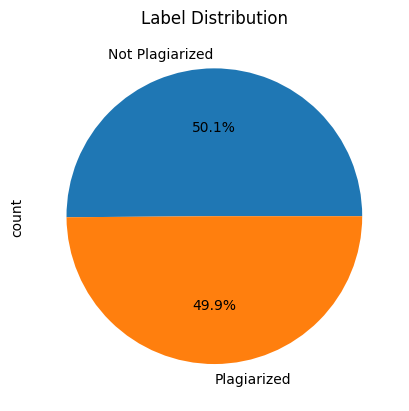

In [7]:
# check value counts
print(df['label'].value_counts())

# Pie Chart
df['label'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Not Plagiarized', 'Plagiarized'])
plt.title('Label Distribution')
plt.show()

## *Check the Text Length*

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


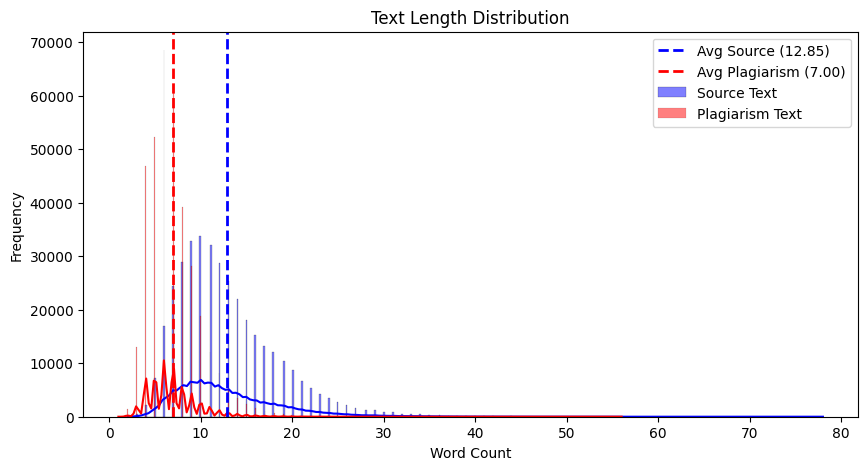

In [8]:
# Calculate source and plagiarism text lengths
df['source_len'] = df['source_txt'].apply(lambda x: len(x.split()))
df['plagiarism_len'] = df['plagiarism_txt'].apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['source_len'], color='blue', label='Source Text', kde=True)
sns.histplot(df['plagiarism_len'], color='red', label='Plagiarism Text', kde=True)

# Calculate averages
avg_source_len = df['source_len'].mean()
avg_plagiarism_len = df['plagiarism_len'].mean()

# Add average lines
plt.axvline(avg_source_len, color='blue', linestyle='dashed', linewidth=2, label=f'Avg Source ({avg_source_len:.2f})')
plt.axvline(avg_plagiarism_len, color='red', linestyle='dashed', linewidth=2, label=f'Avg Plagiarism ({avg_plagiarism_len:.2f})')

# Final touches
plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The plot shows the **text length distribution** for source and plagiarized texts. **Source texts (blue)** are generally longer, averaging **12.85 words**, while **plagiarized texts (red)** are shorter, averaging **7.00 words**.  

Plagiarized texts are more concentrated around shorter lengths, whereas source texts have a broader distribution. This suggests that plagiarism often involves copying shorter text segments.

## *WordCloud*

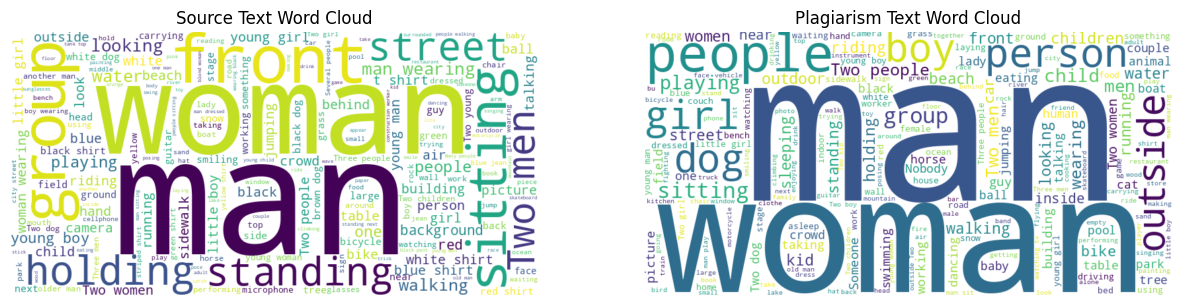

In [10]:


# Generate word cloud for source_txt
source_text = " ".join(df['source_txt'].tolist())
wordcloud_source = WordCloud(width=800, height=400, background_color='white').generate(source_text)

# Generate word cloud for plagiarism_txt
plag_text = " ".join(df['plagiarism_txt'].tolist())
wordcloud_plag = WordCloud(width=800, height=400, background_color='white').generate(plag_text)

# Display the word clouds
plt.figure(figsize=(15, 7))

# Source Text Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_source, interpolation='bilinear')
plt.title('Source Text Word Cloud')
plt.axis('off')

# Plagiarism Text Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_plag, interpolation='bilinear')
plt.title('Plagiarism Text Word Cloud')
plt.axis('off')

plt.show()


## *data Preprocessing*

In [ ]:
%%time
# ========== NLTK Downloads ==========
nltk.download('stopwords')

# ========== Load SpaCy Model for Advanced NLP Tasks ==========
nlp = spacy.load('en_core_web_sm')

# ========== 1. Lowercase ==========
def to_lowercase(text):
    return text.lower()

# ========== 2. Remove Punctuation ==========
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# ========== 3. Remove Special Characters and Numbers ==========
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', '', text)

# ========== 4. Remove HTML Tags ==========
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

# ========== 5. Remove Emojis ==========
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" 
                               u"\U0001F300-\U0001F5FF" 
                               u"\U0001F680-\U0001F6FF" 
                               u"\U0001F700-\U0001F77F" 
                               u"\U0001F780-\U0001F7FF" 
                               u"\U0001F800-\U0001F8FF" 
                               u"\U0001F900-\U0001F9FF" 
                               u"\U0001FA00-\U0001FA6F" 
                               u"\U0001FA70-\U0001FAFF" 
                               u"\U00002702-\U000027B0" 
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# ========== 6. Remove URLs ==========
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# ========== 7. Remove Extra Spaces ==========
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

# ========== 8. Expanding Contractions ==========
def expand_contractions(text):
    return contractions.fix(text)

# ========== 9. Stop Words Removal ==========
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text.split()
    return " ".join([word for word in tokens if word not in stop_words])

# ========== 10. Tokenization and Lemmatization (Using SpaCy) ==========
def spacy_tokenization_lemmatization(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

# ========== 11. Custom Removal (Remove Specific Words) ==========
def remove_specific_words(text, words_to_remove):
    words = text.split()
    filtered_words = [word for word in words if word not in words_to_remove]
    return " ".join(filtered_words)

# ========== Full Preprocessing Pipeline ==========
def full_pipeline(text):
    text = to_lowercase(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_html_tags(text)
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords(text)
    tokens = spacy_tokenization_lemmatization(text)
    text = " ".join(tokens)
    text = remove_specific_words(text, ['chat'])  # Remove 'chat' specifically
    return text


# ========== Apply Pipeline Separately ==========
tqdm.pandas()
df['processed_source_txt'] = df['source_txt'].progress_apply(full_pipeline)
df['processed_plagiarism_txt'] = df['plagiarism_txt'].progress_apply(full_pipeline)

# ========== Final Output ==========
print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'processed_plagiarism_txt']])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


100%|██████████| 366915/366915 [27:00<00:00, 226.42it/s]



========= Final DataFrame =========

                          processed_source_txt  \
0             person horse jump break airplane   
1             person horse jump break airplane   
2                      child smile wave camera   
3                      child smile wave camera   
4        boy jump skateboard middle red bridge   
...                                        ...   
367368       dog blue collar play ball outside   
367369              four dirty barefoote child   
367370              four dirty barefoote child   
367371  man surf bodysuit beautiful blue water   
367372  man surf bodysuit beautiful blue water   

                      processed_plagiarism_txt  
0               person diner ordering omelette  
1                        person outdoors horse  
2                                child present  
3                                    kid frown  
4                           boy skate sidewalk  
...                                        ...  
367368           

## *vectorized data(word2vec)*


In [9]:
%%time
# ========== Required Libraries ==========
from gensim.models import Word2Vec
import numpy as np

# ========== Tokenization for Word2Vec ==========
def tokenize(text):
    return text.split()

# ========== Prepare Sentences for Word2Vec ==========
source_sentences = df['processed_source_txt'].apply(tokenize).tolist()
plagiarism_sentences = df['processed_plagiarism_txt'].apply(tokenize).tolist()

# Combine both for better context learning
all_sentences = source_sentences + plagiarism_sentences

# ========== Train Word2Vec Model ==========
w2v_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)

# ========== Function to Convert Sentence to Vector ==========
def sentence_to_vec(sentence, model):
    # Get vectors for words in the sentence
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    # Calculate mean of vectors to get sentence vector
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# ========== Convert Processed Text to Numeric Vectors ==========
df['source_vec'] = df['processed_source_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))
df['plagiarism_vec'] = df['processed_plagiarism_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))

# ========== Display Result ==========
print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'source_vec', 'processed_plagiarism_txt', 'plagiarism_vec']])




========= Final DataFrame =========

                          processed_source_txt  \
0             person horse jump break airplane   
1             person horse jump break airplane   
2                      child smile wave camera   
3                      child smile wave camera   
4        boy jump skateboard middle red bridge   
...                                        ...   
367368       dog blue collar play ball outside   
367369              four dirty barefoote child   
367370              four dirty barefoote child   
367371  man surf bodysuit beautiful blue water   
367372  man surf bodysuit beautiful blue water   

                                               source_vec  \
0       [0.03123439, 0.03898833, 0.09661384, 0.0559780...   
1       [0.03123439, 0.03898833, 0.09661384, 0.0559780...   
2       [0.14338714, 0.3174157, 0.8467165, -0.5164682,...   
3       [0.14338714, 0.3174157, 0.8467165, -0.5164682,...   
4       [0.7089758, -0.6526105, 0.63404506, -0.3484032.

In [14]:
df.head()

,source_txt,plagiarism_txt,label,processed_source_txt,processed_plagiarism_txt,source_vec,plagiarism_vec
0,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0,person horse jump break airplane,person diner ordering omelette,"[0.33655283, -0.423007, 0.24516356, 0.6499422,...","[0.07593037, -0.5188457, 0.44295275, 0.3111593..."
1,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1,person horse jump break airplane,person outdoors horse,"[0.33655283, -0.423007, 0.24516356, 0.6499422,...","[-0.7400271, -1.6175932, 1.1001302, 1.4627895,..."
2,Children smiling and waving at camera,There are children present,1,child smile wave camera,child present,"[0.13530853, -0.13283068, 0.56107223, -0.40955...","[-0.5158136, 0.55539393, -0.3520202, -0.123184..."
3,Children smiling and waving at camera,The kids are frowning,0,child smile wave camera,kid frown,"[0.13530853, -0.13283068, 0.56107223, -0.40955...","[-0.56272066, -0.52357894, 0.18317525, 0.33076..."
4,A boy is jumping on skateboard in the middle o...,The boy skates down the sidewalk.,0,boy jump skateboard middle red bridge,boy skate sidewalk,"[0.3709927, -0.7545542, 0.43423292, -0.6395784...","[-0.0036233861, -0.6756406, 1.7937828, 0.02142..."


## *ML (RandomForest)*


In [ ]:
# ========== Required Libraries for ML Model==========
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ========== Prepare X and y ==========
# Combine source_vec and plagiarism_vec to form feature set
X = np.vstack([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = df['label'].values

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Train RandomForest Model ==========
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ========== Make Predictions ==========
y_pred = clf.predict(X_test)

# ========== Evaluate Model ==========
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n\n========= Model Evaluation =========\n")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)




========= Model Evaluation =========

Accuracy: 75.12%

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.75     36869
           1       0.75      0.75      0.75     36514

    accuracy                           0.75     73383
   macro avg       0.75      0.75      0.75     73383
weighted avg       0.75      0.75      0.75     73383



## *DL (LSTM with keras tuner)*

In [ ]:
%%time

# ========== Required Libraries for LSTM Model ==========
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# ========== Prepare X and y ==========
# Combine source_vec and plagiarism_vec to form feature set
X = np.array([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = np.array(df['label'].values)

# ========== Reshape Data for LSTM ==========
# LSTM requires 3D input: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Early Stopping Callback ==========
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ========== Hyperparameter Tuning with Keras Tuner ==========
def build_model(hp):
    model = Sequential()

    # ========== Number of LSTM Layers ==========
    # Tune the number of LSTM layers (1 to 3 layers)
    num_layers = hp.Int('num_lstm_layers', min_value=1, max_value=6, step=1)
    
    for i in range(num_layers):
        # LSTM Layer with hyperparameter tuning for units
        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i+1}', min_value=32, max_value=128, step=32),
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=True if i < num_layers - 1 else False)
        )
        
        # Dropout Layer with hyperparameter tuning for rate
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i+1}', min_value=0.2, max_value=0.5, step=0.1)))

    # ========== Dense Layer ==========
    # Dense layer with hyperparameter tuning for units and activation function
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])
    ))
    
    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # ========== Optimizer and Learning Rate ==========
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer == 'adam':
        optim = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    else:
        optim = tf.keras.optimizers.RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    
    # Compile the model
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# ========== Initialize the Hyperparameter Tuner ==========
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='keras_tuner',
    project_name='lstm_layers_tuning'
)

# ========== Search for the Best Hyperparameters ==========
tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# ========== Get the Best Hyperparameters ==========
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"\n\nBest Hyperparameters: \n{best_hyperparameters.values}")

# ========== Build and Train the Best Model ==========
best_model = tuner.hypermodel.build(best_hyperparameters)
history = best_model.fit(X_train, y_train, initial_epoch=5, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# ========== Evaluate the Best Model ==========
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\n\nBest Model Accuracy: {accuracy * 100:.2f}%")

# ========== Make Predictions ==========
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# ========== Display Classification Report ==========
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Trial 10 Complete [00h 03m 17s]
val_accuracy: 0.8152569532394409

Best val_accuracy So Far: 0.8316231369972229
Total elapsed time: 00h 31m 59s


Best Hyperparameters: 
{'num_lstm_layers': 3, 'lstm_units_1': 96, 'dropout_rate_1': 0.4, 'dense_units': 32, 'dense_activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00046191802419367296, 'lstm_units_2': 32, 'dropout_rate_2': 0.4, 'lstm_units_3': 64, 'dropout_rate_3': 0.2, 'lstm_units_4': 96, 'dropout_rate_4': 0.2, 'lstm_units_5': 64, 'dropout_rate_5': 0.2, 'lstm_units_6': 96, 'dropout_rate_6': 0.4, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0002'}
Epoch 6/50
9173/9173 ━━━━━━━━━━━━━━━━━━━━ 65s 7ms/step - accuracy: 0.7118 - loss: 0.5391 - val_accuracy: 0.7993 - val_loss: 0.4231
Epoch 7/50
9173/9173 ━━━━━━━━━━━━━━━━━━━━ 62s 7ms/step - accuracy: 0.7931 - loss: 0.4350 - val_accuracy: 0.8168 - val_loss: 0.3976
Epoch 8/50
9173/9173 ━━━━━━━━━━━━━━━━━━━━ 61s 7ms/step - accuracy: 0.81

## *History plot*

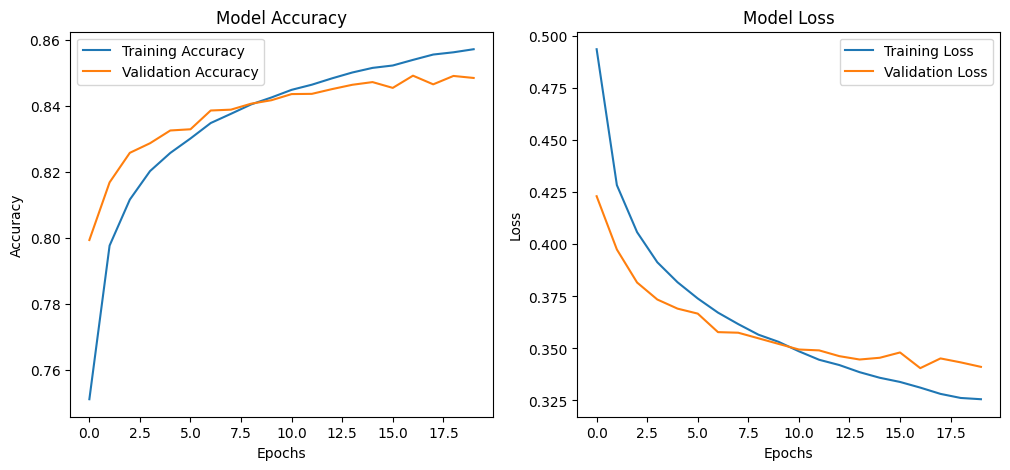

In [11]:
# ========== Plot Training History ==========
# Accuracy Plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## **🎈Save Model**

In [ ]:
# import pickle
# pickle.dump(best_model,open('best_model.pkl','wb'))
# import pickle

# Save the complete Word2Vec model
# pickle.dump(w2v_model, open('word2vec_model.pkl', 'wb'))